In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Language Modeling

## Data
The [large movie view dataset](http://ai.stanford.edu/-amass/data/sentiment/) cotains a collection of 50,000 reviews from IMDB. The dtatset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative reveiw has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews. 

The **sentiment classifcation task** consists of predicting the polarity (positive or negative) of a given text. 

However, before we try to classify *sentiment*, we will create a *language model*. That is, we will create a model taht can predict the next word in a sentence. Why? Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment. 

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (predict the next word) and fine tunt it to do something else (classify sentiment). 

Unfortunately, there are no good pretrained language models available to download, so we need to create our own. To follow along with this notebook, we suggest downloading the data from [this location](http://files.fast.ai/data/aclImdb.tgz) on files.fast.ai.

In [3]:
PATH='data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

imdbEr.txt  imdb.vocab  models/  README  test/  tmp/  train/


Let's look inside the training folder!

In [4]:
trn_files = !ls {TRN}
trn_files[:10]

['0_0.txt',
 '0_3.txt',
 '0_9.txt',
 '10000_0.txt',
 '10000_4.txt',
 '10000_8.txt',
 '1000_0.txt',
 '10001_0.txt',
 '10001_10.txt',
 '10001_4.txt']

And, let's look at an example review.

In [5]:
review = !cat {TRN}{trn_files[6]}
review[0]

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop-socky fung-ku, but what I got instead was a comedy. So, it wasn't quite was I was expecting, but I really liked it anyway! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them!! I was laughing my ass off. I mean, the cops were just so bad! And when I say bad, I mean The Shield Vic Macky bad. But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose...man, oh man. What can you say about that hottie. She was great and put those other actresses to shame. She should work more often!!!!! I also really liked the fight scene outside of the building. That was done really well. Lots of fighting and people getting their heads banged up. FUN! Last, but not least Joe Estevez and William Smith were great as the...well, I wasn't sure what they were, but they seemed to be having fun and throwing out 

Sounds like we'd really enjoy that movie!

Now, we'll check how many words are in the dataset. 

In [6]:
!find {TRN} -name '*.txt' | xargs cat | wc -w

17486581


In [7]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

5686719


Before we can analyze text, we must first _tokenize_ it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of _tokens_).

_Note_: if you get an error like:

    Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package, or a valid path to a data directory.
    
then you need to install the Spacy language model by running this command on the command-line: 

    $ python -m spacy download en

In [8]:
spacy_tok = spacy.load('en')

In [9]:
' '.join([sent.string.strip() for sent in spacy_tok(review[0])])

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop - socky fung - ku , but what I got instead was a comedy . So , it was n't quite was I was expecting , but I really liked it anyway ! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them ! ! I was laughing my ass off . I mean , the cops were just so bad ! And when I say bad , I mean The Shield Vic Macky bad . But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose ... man , oh man . What can you say about that hottie . She was great and put those other actresses to shame . She should work more often ! ! ! ! ! I also really liked the fight scene outside of the building . That was done really well . Lots of fighting and people getting their heads banged up . FUN ! Last , but not least Joe Estevez and William Smith were great as the ... well , I was n't sure what they were , but they see

I'm using Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text. In this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [10]:
TEXT = data.Field(lower=True, tokenize="spacy") 

`fastai` works closely with `torchtext`. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passit it our torchtext field object, as well as the paths to our training, test, and validation sets. In this case, we don't have a separate text set, so we'll just use `VAL_PATH` for that, too. 
As well as the usual `bs` (batch size) parameter, we also now have `bptt`, which defines how many words are processing at a time in each row of the mini-batch. More importantly, it definies how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences. 

In [11]:
bs=64; bptt=70

In [12]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a _vocabulary_, which stores which words (or _tokens_) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it. 
(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of the notebook we used the `dill` library instead and imported it as `pickle`). 

In [13]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the # batches; # unique tokens in the vocab; # tokens in the training set; # sentences.

In [14]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(4583, 37392, 1, 20540756)

In [15]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [16]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['the']

2

Note that in a `LanguageModelData` object there is only one item in each dataset; all the words of the text joined together. 

In [17]:
md.trn_ds[0].text[:12]

['at',
 'first',
 ',',
 'i',
 'thought',
 'this',
 'was',
 'a',
 'sequel',
 'to',
 'entre',
 'nous']

torchtext will handle turning these words into integer IDs for us automatically.

In [18]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
    40
   102
     3
    12
   213
    13
    19
     6
   701
     8
 36172
     0
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

Our `LanguageMOdelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - _backprop through time_).
Each batch also contains the exact same data as labels, but one word later in the text - since we're always trying to predict the next words. The labels are flattened into a 1d array.

In [19]:
next(iter(md.trn_dl))

(Variable containing:
     40     20     11  ...      20     11   2519
    102      6     16  ...    9324     27      4
      3   8852     31  ...      20      2      8
         ...            ⋱           ...         
    482    221    457  ...      13     82     10
    279   1501      3  ...       9     29      0
    588     53    113  ...      31   1404      2
 [torch.cuda.LongTensor of size 67x64 (GPU 0)], Variable containing:
    102
      6
     16
   ⋮   
      6
     84
    491
 [torch.cuda.LongTensor of size 4288 (GPU 0)])

## Train
We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems. 

In [20]:
em_sz = 200 # size of each embedding vector
nh = 500    # number of hidden activiations per layer
nl = 3      # number of layers

Researchers have found that large amounts of _momentum_ (which we'll learn about later) don't work well with these kinds of _RNN_ models, so we create a version of the _Adam_ optimizer with less momentum than its default of `0.9`.

In [21]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet) to find the best values of the dropout parameters below - you just have to experiment.
However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [22]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

As we can see below, I'm gradually tuning the language model in a few stages. First, I use `lr_find` to find a good learning rate.

In [22]:
lrf=learner.lr_find()

 83%|████████▎ | 3804/4583 [17:05<03:29,  3.71it/s, loss=20.8]

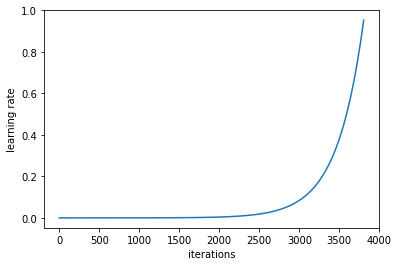

In [23]:
learner.sched.plot_lr()

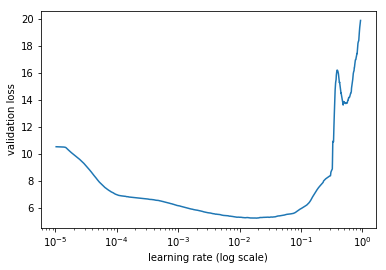

In [24]:
learner.sched.plot()

In [25]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                
    0      4.837053   4.714542  
    1      4.653745   4.523437                                
    2      4.539486   4.44036                                 
    3      4.597858   4.4662                                  
    4      4.512934   4.392785                                
    5      4.439105   4.337126                                
    6      4.408612   4.320076                                
    7      4.539262   4.41636                                 
    8      4.509952   4.387079                                
    9      4.480105   4.356027                                
    10     4.429727   4.321282                                
    11     4.38593    4.291988                                
    12     4.348661   4.268082                                
    13     4.32632    4.254528                                
    14     4.319645   4.251568                                


[array([4.25157])]

In [26]:
learner.save_encoder('adam1_enc')

In [23]:
learner.load_encoder('adam1_enc')

In [24]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

epoch      trn_loss   val_loss                                
    0      4.483237   4.366386  
    1      4.468298   4.352488                                
    2      4.461535   4.338095                                
    3      4.427455   4.313095                                
    4      4.391121   4.288256                                
    5      4.36358    4.268044                                
    6      4.318294   4.247437                                
    7      4.304023   4.233534                                
    8      4.291785   4.225533                                
    9      4.273076   4.223787                                



[array([4.22379])]

In [25]:
learner.save_encoder('adam3_10_enc')

In [26]:
learner.load_encoder('adam3_10_enc')

Language modeling accuracy is generally measured using the metric _perplexity_, which is simply `exp()` of the loss function we used.

In [27]:
math.exp(4.165)

64.3926824434624

In [29]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

## Test
We can play around with our language model a bit to check if it seems to be working OK> First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it into our language model.

In [30]:
m = learner.model
ss = """. So, it wasn't quite what I was expecting, but I really liked it anyway! The best"""""
s = [TEXT.preprocess(ss)]
t = TEXT.numericalize(s)
' '.join(s[0])

". so , it was n't quite what i was expecting , but i really liked it anyway ! the best"

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [31]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res, *_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [32]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['part',
 'thing',
 'scene',
 'parts',
 'of',
 'way',
 'scenes',
 'aspect',
 'i',
 'movie']

and, let's see if our model can generate a bit more text all by itself!

In [35]:
print(ss, "/n")
for i in range(50):
    n = res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res, *_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite what I was expecting, but I really liked it anyway! The best /n
part of the film . the film is a bit of a mess , but it is a good one . <eos> i saw this movie at the toronto film festival . i was very disappointed . i was n't expecting much from this movie , but i was n't ...


## Sentiment
We'll need to use the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [37]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).
`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets. 

In [38]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

downloading aclImdb_v1.tar.gz


In [39]:
t = splits[0].examples[0]

In [40]:
t.label, ' '.join(t.text[:16])

('pos',
 "fantastic documentary of 1924 . this early 20th century geography of today 's iraq was powerful")

fastai can create a ModelData object directly from torchtext splits.

In [41]:
md2 = TextData.from_splits(PATH, splits, bs)

In [43]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_10_enc')

Becaues we're fine tuning a pretrained model, we'll use differential learning rates and also increase the max gradient for clipping, to allow the SGDR to work better. 

In [44]:
m3.clip=25.
lr=np.array([1e-4, 1e-4, 1e-4, 1e-3, 1e-2])

In [47]:
m3.freeze_to(-1)
m3.fit(lr/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lr, 1, metrics=[accuracy], cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.411763   0.320063   0.889965  



epoch      trn_loss   val_loss   accuracy                    
    0      0.381183   0.252349   0.90178   



[array([0.25235]), 0.9017803630918152]

In [48]:
m3.fit(lr, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

epoch      trn_loss   val_loss   accuracy                    
    0      0.354735   0.229099   0.911775  
    1      0.333554   0.23661    0.907276                    
    2      0.307881   0.207148   0.921718                    
    3      0.308521   0.210485   0.919715                    
    4      0.30336    0.209987   0.920167                    
    5      0.300114   0.199029   0.926079                    
    6      0.296678   0.205117   0.922508                    
    7      0.277322   0.196986   0.927878                    
    8      0.28284    0.195496   0.923963                    
    9      0.254221   0.189986   0.929727                    
    10     0.269615   0.190016   0.928955                    
    11     0.263257   0.186133   0.931775                    
    12     0.255306   0.184358   0.931808                    
    13     0.246201   0.183361   0.932718                    



[array([0.18336]), 0.9327179344853301]

In [49]:
m3.load_cycle('imdb2', 4)

In [51]:
accuracy_np(*m3.predict_with_targs())

0.93164

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms show are tuned for this specific problem.

![image.png](image.png)

As you can see, the result here is a top of the line result in sentiment analysis, what would be a top-5 finish compared to these others. We should be able to get similarly world-class resutls on other NLP classification problems using the same basic steps. 

There are also many opportunites to further improve this, but we won't be able to get to them until part 2 of this course. 

## End